# seq2seq 모델

In [44]:
import pandas as pd
from keras.utils import to_categorical, model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
import numpy as np

from IPython.display import SVG
from keras_preprocessing.sequence import pad_sequences

## 데이터 불러오기

In [45]:
df = pd.read_csv('./data/kor-eng/kor.txt', names=['src', 'tar', 'lic'], sep='\t')
del df['lic']
print('전체 샘플의 개수 :',len(df))

전체 샘플의 개수 : 3798


In [46]:
df = df[0:60000] # 6만개만 저장
df.sample(10)

,src,tar
2459,What are you two arguing about?,너희 둘 무엇에 관하여 논쟁하고 있니?
585,It's not funny.,안 재밌어.
28,I know.,알아.
2972,He's not going to visit you tomorrow.,그 사람은 내일 너를 보러 가지 않을 거야.
744,I'm your teacher.,난 네 선생이다.
3429,Does anybody here know how this thing works?,이걸 어떻게 하는지 아는 사람?
670,Keep the change.,잔돈은 가지세요.
1809,Why are you still working?,왜 아직도 일하고 있어?
3146,I wonder if Tom noticed the difference.,톰이 다른 점을 눈치챘는지 의문스러워.
2874,Tom is in his mid-to-late thirties.,톰은 삼십대 중반이야.


In [47]:
df.head(10)

,src,tar
0,Go.,가.
1,Hi.,안녕.
2,Run!,뛰어!
3,Run.,뛰어.
4,Who?,누구?
5,Wow!,우와!
6,Fire!,쏴!
7,Help!,도와줘!
8,Jump!,점프!
9,Jump.,점프해.


In [48]:
df.tail()

,src,tar
3793,Science fiction has undoubtedly been the inspi...,공상 과학 소설은 의심의 여지 없이 오늘날 존재하는 많은 기술에 영감을 주었어.
3794,I started a new blog. I'll do my best not to b...,난 블로그를 시작했어. 블로그를 초반에만 반짝 많이 하다가 관두는 사람처럼은 되지 ...
3795,I think it's a shame that some foreign languag...,몇몇 외국어 선생님이 한 번도 원어민과 공부해본 적도 없으면서 대학을 나올 수 있었...
3796,If someone who doesn't know your background sa...,만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어...
3797,Doubtless there exists in this world precisely...,의심의 여지 없이 세상에는 어떤 남자이든 정확히 딱 알맞는 여자와 결혼하거나 그 반...


## 데이터 전처리

In [49]:
'''
시작을 의미하는 심볼 '\t'
종료를 의미하는 심볼 '\n'
'''
df.tar = df.tar.apply(lambda x : '\t '+ x + ' \n')
df.sample(10)

,src,tar
422,It's suicide.,\t 자살입니다. \n
726,Her hair is long.,\t 그녀의 머리카락은 길다. \n
1841,I didn't know who you were.,\t 네가 누군지 난 몰랐어. \n
3233,I wish I could go to the party with you.,\t 너랑 같이 파티 갔으면 좋았을텐데 \n
2998,I'm trying to help you keep your job.,\t 나는 니가 일을 계속하게 도와주고 싶어. \n
3721,"If God did not exist, it would be necessary to...","\t 만약 신이 존재하지 않았다면, 만들어 낼 필요가 있겠지. \n"
3186,What did you do after school yesterday?,\t 너 어제 학교 끝나고 뭐했어? \n
196,Be careful.,\t 조심해! \n
2176,Mary is wearing a silk dress.,\t 메리는 비단으로 된 드레스를 입고 있어. \n
2872,Tom is having a hard time focusing.,\t 톰은 집중하려고 애를 쓰고 있어. \n


In [50]:
# 문자 집합 구축
src_vocab = set()
for line in df.src: # 1줄씩 읽음
    for char in line: # 1개의 문자씩 읽음
        src_vocab.add(char)

tar_vocab = set()
for line in df.tar:
    for char in line:
        tar_vocab.add(char)

In [51]:
src_vocab_size = len(src_vocab)
tar_vocab_size = len(tar_vocab)
print('source 문장의 char 집합 :',src_vocab_size)
print('target 문장의 char 집합 :',tar_vocab_size)

source 문장의 char 집합 : 74
target 문장의 char 집합 : 917


In [52]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab)
print(tar_vocab[45:75])

[' ', '!', '"', '$', '%', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '°', 'ï']
['간', '갇', '갈', '감', '갑', '값', '갔', '강', '갖', '같', '개', '객', '갰', '걀', '걔', '거', '걱', '건', '걷', '걸', '검', '겁', '것', '게', '겐', '겠', '겨', '격', '겪', '견']


In [53]:
# 각 문자에 인덱스 부여
src_to_index = dict([(char, i+1) for i, char in enumerate(src_vocab)])
tar_to_index = dict([(char, i+1) for i, char in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, "'": 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'Y': 46, 'a': 47, 'b': 48, 'c': 49, 'd': 50, 'e': 51, 'f': 52, 'g': 53, 'h': 54, 'i': 55, 'j': 56, 'k': 57, 'l': 58, 'm': 59, 'n': 60, 'o': 61, 'p': 62, 'q': 63, 'r': 64, 's': 65, 't': 66, 'u': 67, 'v': 68, 'w': 69, 'x': 70, 'y': 71, 'z': 72, '°': 73, 'ï': 74}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '%': 6, '(': 7, ')': 8, ',': 9, '-': 10, '.': 11, '/': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, ':': 23, '?': 24, 'A': 25, 'B': 26, 'C': 27, 'D': 28, 'H': 29, 'M': 30, 'N': 31, 'T': 32, 'a': 33, 'd': 34, 'h': 35, 'i': 36, 'm': 37, 'o': 38, 'p': 3

### 데이터 정수 인코딩

In [54]:
encoder_input = []

# 1개의 문장
for line in df.src:
  encoded_line = []
  # 각 줄에서 1개의 char
  for char in line:
    # 각 char을 정수로 변환
    encoded_line.append(src_to_index[char])
  encoder_input.append(encoded_line)

print('source 문장의 정수 인코딩 :',encoder_input[:5])

source 문장의 정수 인코딩 : [[29, 61, 9], [30, 55, 9], [40, 67, 60, 2], [40, 67, 60, 9], [45, 54, 61, 22]]


In [55]:
decoder_input = []

for line in df.tar:
  decoded_line = []
  for char in line:
    decoded_line.append(tar_to_index[char])
  decoder_input.append(decoded_line)

print('target 문장의 정수 인코딩 :',decoder_input[:5])

target 문장의 정수 인코딩 : [[1, 3, 44, 11, 3, 2], [1, 3, 552, 196, 11, 3, 2], [1, 3, 289, 574, 4, 3, 2], [1, 3, 289, 574, 11, 3, 2], [1, 3, 207, 96, 24, 3, 2]]


In [56]:
'''
디코더의 예측값과 비교하기 위한 실제값은
시작 심볼에 해당되는 <sos>가 있을 필요가 없다.

따라서 정수 인코딩 과정에서 <sos>를 제거한다.
'''
decoder_target = []

for line in df.tar:
  timestep = 0
  decoded_line = []
  for char in line:
    if timestep > 0:
      decoded_line.append(tar_to_index[char])
    timestep = timestep + 1
  decoder_target.append(decoded_line)

print('target 문장 레이블의 정수 인코딩 :',decoder_target[:5])

target 문장 레이블의 정수 인코딩 : [[3, 44, 11, 3, 2], [3, 552, 196, 11, 3, 2], [3, 289, 574, 4, 3, 2], [3, 289, 574, 11, 3, 2], [3, 207, 96, 24, 3, 2]]


### 데이터 패딩 처리

In [57]:
max_src_len = max([len(line) for line in df.src])
max_tar_len = max([len(line) for line in df.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 537
target 문장의 최대 길이 : 300


In [58]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

### 데이터 원 핫 인코딩

In [59]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

In [60]:
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(3798, 537, 75)
(3798, 300, 918)
(3798, 300, 918)


## 모델 생성

In [61]:
encoder_inputs = Input(shape=(None, src_vocab_size+1))
encoder_lstm = LSTM(units=256, return_state=True)

# encoder_outputs은 여기서는 불필요
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 은닉 상태와 셀 상태.
encoder_states = [state_h, state_c]

In [62]:
decoder_inputs = Input(shape=(None, tar_vocab_size+1))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# 디코더에게 인코더의 은닉 상태, 셀 상태를 전달.
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_softmax_layer = Dense(tar_vocab_size+1, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [63]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 75)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, 918)]  0           []                               
                                                                                                  
 lstm_4 (LSTM)                  [(None, 256),        339968      ['input_5[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

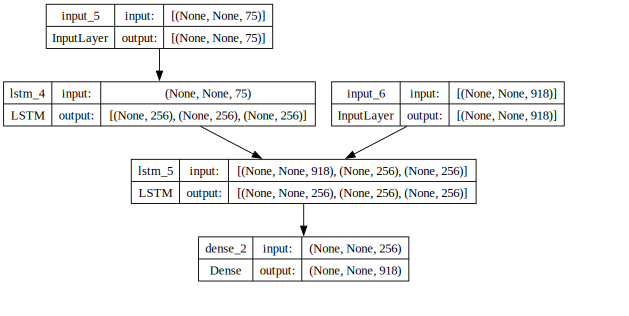

In [73]:
# %matplotlib inline

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [65]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy",metrics=['acc'])

In [66]:
model_path = './model/model.ep{epoch:02d}.val_loss{val_loss:.4f}.h5'

callbacks = [EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=False),
             ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)]

In [67]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=40, validation_split=0.2, callbacks=callbacks)

Epoch 1/40


2023-10-29 15:13:09.778853: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-10-29 15:13:11.020032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:13:11.478282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:13:19.465142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:13:22.736060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:13:50.654664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - ETA: 0s - loss: 0.7977 - acc: 0.9177

2023-10-29 15:17:43.795609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:17:44.067974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:17:52.072150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 298s 4s/step - loss: 0.7977 - acc: 0.9177 - val_loss: 0.7017 - val_acc: 0.9110
Epoch 2/40
48/48 [==============================] - 19s 400ms/step - loss: 0.2963 - acc: 0.9547 - val_loss: 0.5458 - val_acc: 0.9209
Epoch 3/40
48/48 [==============================] - 19s 392ms/step - loss: 0.2383 - acc: 0.9567 - val_loss: 0.6373 - val_acc: 0.9212
Epoch 4/40
48/48 [==============================] - 19s 397ms/step - loss: 0.2264 - acc: 0.9582 - val_loss: 0.4534 - val_acc: 0.9272
Epoch 5/40
48/48 [==============================] - 19s 395ms/step - loss: 0.2100 - acc: 0.9615 - val_loss: 0.3902 - val_acc: 0.9361
Epoch 6/40
48/48 [==============================] - 19s 396ms/step - loss: 0.1960 - acc: 0.9647 - val_loss: 0.3609 - val_acc: 0.9408
Epoch 7/40
48/48 [==============================] - 19s 401ms/step - loss: 0.1790 - acc: 0.9676 - val_loss: 0.3539 - val_acc: 0.9422
Epoch 8/40
48/48 [==============================] - 20s 415ms/step - loss: 0.1714 

## 모델 테스트

In [68]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [69]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 뒤의 함수 decode_sequence()에 동작을 구현 예정
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태를 버리지 않음.
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [70]:
'''
단어로부터 인덱스를 얻는 것이 아닌
인덱스로부터 단어를 얻을 수 있는 index_to_src와 index_to_tar
'''
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

In [71]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 원-핫 벡터 생성
  target_seq = np.zeros((1, 1, tar_vocab_size+1))
  target_seq[0, 0, tar_to_index['\t']] = 1.

  stop_condition = False
  decoded_sentence = ""

  # stop_condition이 True가 될 때까지 루프 반복
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 문자로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 문자를 예측 문장에 추가
    decoded_sentence += sampled_char

    # <eos>에 도달하거나 최대 길이를 넘으면 중단.
    if (sampled_char == '\n' or
        len(decoded_sentence) > max_tar_len):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1, 1, tar_vocab_size+1))
    target_seq[0, 0, sampled_token_index] = 1.

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [72]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
  input_seq = encoder_input[seq_index:seq_index+1]
  decoded_sentence = decode_sequence(input_seq)
  print(35 * "-")
  print('입력 문장:', df.src[seq_index])
  print('정답 문장:', df.tar[seq_index][2:len(df.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
  print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력

2023-10-29 15:25:19.156183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:25:19.212602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step


2023-10-29 15:25:27.712574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:25:27.769893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 11ms/step
-----------------------------------
입력 문장: Run.
정답 문장: 뛰어. 
번역 문장: 톰은 메리를 자기 있을 거야. 
1/1 [==============================] - 0s 10ms/step
-----------------------------------
입력 문장: Help me.
정답 문장: 도와줘. 
번역 문장: 톰은 메리를 자기 있을 거야. 
1/1 [==============================] - 0s 12ms/step
-----------------------------------
입력 문장: Tom lost.
정답 문장: 톰이 졌어. 
번역 문장: 톰은 메리를 자기 있을 거야. 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Come closer.
정답 문장: 가까이 와. 
번역 문장: 톰은 메리를 자기 있을 거야. 
1/1 [==============================] - 0s 12ms/step
-----------------------------------
입력 문장: Everything's normal.
정답 문장: 모든 것이 정상이야. 
번역 문장: 톰은 메리를 자기 있을 거야. 
